# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [1]:
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal

# modify to where you store your project data including utils.py
datadir = "C:/Users/jackt/Desktop/CS445/cs445hybrid/data/" 

# utilfn = datadir + "utils.py"
# !cp "$utilfn" .
import utils

In [2]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
im1_file = datadir + 'mav.jpg'
im2_file = datadir + 'wolf.jpg'

im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE) / 255.0)
im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE) / 255.0)

In [4]:
pts_im1 = utils.prompt_eye_selection(im1)
# pts_im1 = np.array([[607, 290], [748, 370]]) # uncomment if entering [x, y] pts manually
# plt.plot(pts_im1[:,0], pts_im1[:,1], 'r-+')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


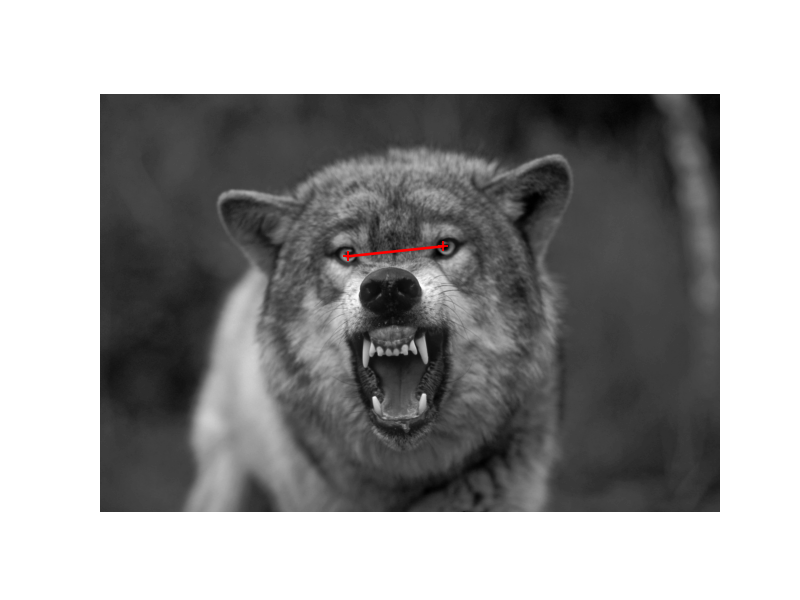

In [5]:
pts_im2 = utils.prompt_eye_selection(im2)
# pts_im2 = np.array([[299,343], [439,331]]) # uncomment if entering [x, y] pts manually
# plt.plot(pts_im2[:,0], pts_im2[:,1], 'r-+')

In [6]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)


In [7]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

<IPython.core.display.Javascript object>


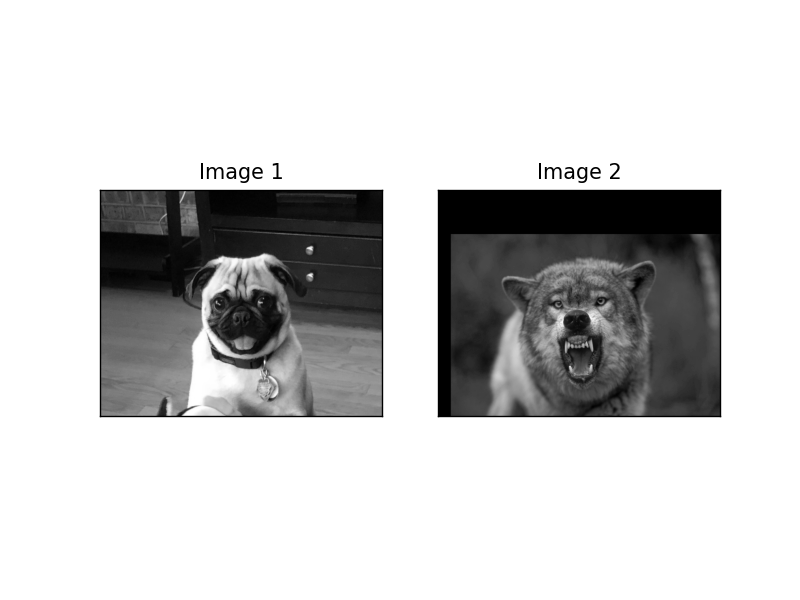

In [8]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([]);

In [9]:
def hybridImage(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''
    is_rgb = (im1.shape == 3)  #TODO B&W handle this case
    
    # Create Gaussian kernel for low frequency filtering
    kernel_half_size = 3*sigma_low
    kernel = utils.gaussian_kernel(sigma_low, kernel_half_size)
    
    # Apply low filter to first image
    fim1 = cv2.filter2D(im1, -1, kernel)
    
    # Create kernel for high frequency filtering
    kernel_half_size = 3*sigma_high
    kernel = -1*utils.gaussian_kernel(sigma_high, kernel_half_size)
    kernel[kernel_half_size,kernel_half_size] += 1
    
    # Apply high filter to second image
    fim2 = cv2.filter2D(im2,-1,kernel)
    
    # Combine the images into one
    hybrid = fim1+fim2
    hybrid /= 2
    
    return hybrid #, fim1, fim2


In [10]:
sigma_low = 2 # choose parameters that work for your images
sigma_high = 10

im_hybrid = hybridImage(im1, im2, sigma_low, sigma_high)

<IPython.core.display.Javascript object>


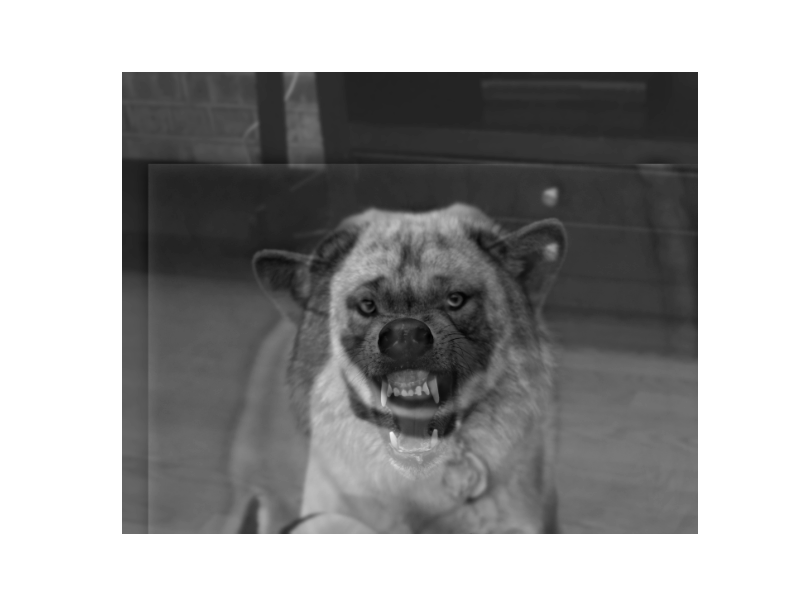

In [11]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

In [12]:
%matplotlib inline

path = "C:/Users/jackt/Desktop/CS445/cs445hybrid/data/plate.jpg" 
im = cv2.imread(path, cv2.IMREAD_COLOR)
im = im[:,:,::-1]

In [13]:
def enhance_contrast(im, sigma):
    '''
    Contrast enhancement using Laplacian filtering
    '''
    # Create Laplacian kernel for filtering
    khs = 3*sigma
    kernel = -1 * utils.gaussian_kernel(sigma, khs)
    kernel[khs,khs] += 2
    
    # Apply filter to image
    fim = cv2.filter2D(im, -1, kernel)
    return fim

In [14]:
fim = enhance_contrast(im, 5)

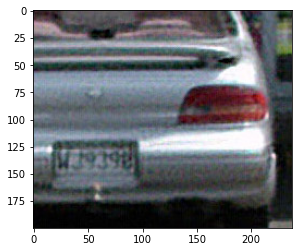

In [15]:
plt.imshow(im)

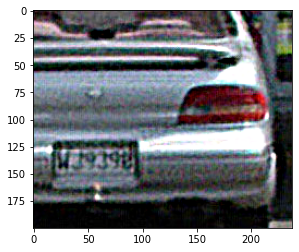

In [16]:
plt.imshow(fim)

#### Color enhancement 

In [17]:
def enhance_color(im, delta_s, delta_v):
    '''
    Color enhancement in HSV image im
    
    Increase S and V channels while staying in 0-255 range
    '''
    if delta_s < 1:
        delta_s = 1
    if delta_v < 1:
        delta_v = 1
    cim = im.copy()
    cim[:,:,1] = 255 - (255 - cim[:,:,1]) // delta_s
    cim[:,:,2] = 255 - (255 - cim[:,:,2]) // delta_v
    return cim

In [18]:
path = "C:/Users/jackt/Desktop/CS445/cs445hybrid/data/mav2.jpg" 
im = cv2.imread(path, cv2.IMREAD_COLOR)
hsv = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)

In [19]:
cim = enhance_color(hsv, 1.1, 1.2)

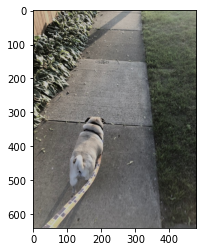

In [20]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

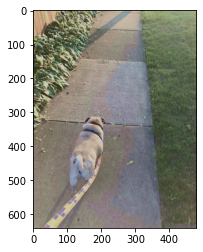

In [21]:
plt.imshow(cv2.cvtColor(cim, cv2.COLOR_HSV2RGB))

#### Color shift

In [22]:
def shift_color(im, tgtH, delta):
    '''
    Color shift in HSV towards target tgtH
    
    Decrease radial distance of each pixel from tgtH 
      by at most delta degrees
    '''
    if delta < 0:
        delta = 0
    sim = im.copy()
    x = ((sim[:,:,0] - tgtH + 180) % 360) - 180
    x = x * delta // -180
    sim[:,:,0] = (sim[:,:,0] + x) % 360
    return sim

In [23]:
path = "C:/Users/jackt/Desktop/CS445/cs445hybrid/data/mav.jpg" 
im = cv2.imread(path, cv2.IMREAD_COLOR)
hsv = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)

In [24]:
imLessYellow = shift_color(hsv, 240, 30) # yellow = 60, opposite = 60+180 = 240

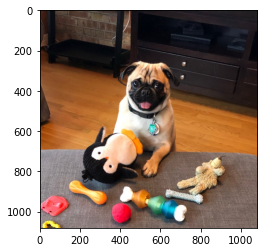

In [25]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

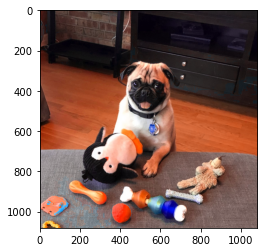

In [26]:
plt.imshow(cv2.cvtColor(imLessYellow, cv2.COLOR_HSV2RGB))

In [27]:
imMoreRed = shift_color(hsv, 0, 30)

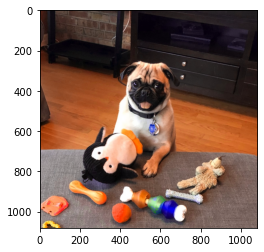

In [28]:
plt.imshow(cv2.cvtColor(imMoreRed, cv2.COLOR_HSV2RGB))